# DEVELOPING A TRADING STRATEGY FOR THE LARGEST STOCKS BY MARKET CAPITALIZATION IN THE COLOMBO STOCK EXCHANGE USING UNSUPERVISED LEARNING

#### Group No: 92

K.R.C.S Kekulawala (EG/2021/4609)

M.A.P Imalsha (EG/2021/4562)

# Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web # Extract data from Internet sources into pandas DataFrames
import pandas_ta # A technical analyss library for stocks
from statsmodels.regression.rolling import RollingOLS # The RollingOLS linear regression model
import statsmodels.api as sm
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data preparation

## Read Company data obtained from simplywall.com

In [2]:
cse = pd.read_csv('cse_companies.csv')
cse.head()

,Ticker Symbol,Company Name,Last Price,7D Return,1Y Return,Market Cap,Analysts Target,Valuation,Growth,Div Yield,Industry
0,EXPO.N0000,Expolanka Holdings,LK₨150.50,0.000,0.132,LK₨294.2b,NaN,PS1.2x,NaN,2.30%,Transportation
1,JKH.N0000,John Keells Holdings,LK₨193.25,-0.004,0.157,LK₨289.6b,LK₨252.97,PE25.8x,E55.5%,0.80%,Capital Goods
2,CTC.N0000,Ceylon Tobacco,"LK₨1,235.00",0.004,0.345,LK₨231.3b,"LK₨1,256.73",PE8.1x,E7.9%,12.00%,"Food, Beverage & Tobacco"
3,LOLC.N0000,LOLC Holdings,LK₨439.00,-0.005,-0.11,LK₨208.6b,NaN,PE7x,NaN,0%,Diversified Financials
4,LOFC.N0000,LOLC Finance,LK₨6.10,0.000,0.017,LK₨201.8b,NaN,PE9.4x,NaN,NaN,Diversified Financials


## List of Industries

In [3]:
industries = cse.Industry.unique()
industries

array(['Transportation', 'Capital Goods', 'Food, Beverage & Tobacco',
       'Diversified Financials', 'Telecom', 'Banks', 'Consumer Retailing',
       'Energy', 'Insurance', 'Consumer Durables', 'Materials',
       'Healthcare', 'Utilities', 'Consumer Services',
       'Real Estate Management and Development', 'Retail', 'Software',
       'Automobiles', 'Household', 'Commercial Services'], dtype=object)

## List of Ticker Symbols

In [4]:
cse['Ticker'] = cse['Ticker Symbol'].str.replace('.' , '-') + '.CM'
tickers_list = cse['Ticker'].tolist()
tickers_list[:5]

['EXPO-N0000.CM',
 'JKH-N0000.CM',
 'CTC-N0000.CM',
 'LOLC-N0000.CM',
 'LOFC-N0000.CM']

## Get the stock data of 10 years from Yahoo Finance

In [5]:
start_date = '2014-01-01'
end_date = '2023-12-31'

df = yf.download(tickers=tickers_list,
                 start=start_date,
                 end=end_date).stack(future_stack=True)
df

[*********************100%%**********************]  282 of 283 completed

14 Failed downloads:
['SWAD-N0000.CM', 'LCBF-N0000.CM', 'LUMX-N0000.CM', 'HELA-N0000.CM', 'CALT-N0000.CM', 'GSF-N0000.CM', 'LGIL-N0000.CM', 'COOP-N0000.CM', 'LPL-N0000.CM', 'HBS-N0000.CM', 'EXT-N0000.CM', 'FCT-N0000.CM', 'HVA-N0000.CM']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['CBNK-N0000.CM']: YFChartError("%ticker%: Data doesn't exist for startDate = 1388514600, endDate = 1703961000")


Price                      Adj Close       Close        High         Low  \
Date       Ticker                                                          
2014-01-02 AAF-N0000.CM    18.750000   19.607843   20.588236   18.627451   
           AAIC-N0000.CM    5.422132    8.550000    8.550000    8.540000   
           ABAN-N0000.CM   83.430321  113.900002  116.000000  108.000000   
           ABL-N0000.CM          NaN         NaN         NaN         NaN   
           ACAP-N0000.CM   17.000000   17.000000   17.100000   16.500000   
...                              ...         ...         ...         ...   
2023-12-29 VPEL-N0000.CM    5.319755    7.200000    7.400000    7.100000   
           WAPO-N0000.CM   25.600000   25.600000   25.900000   25.000000   
           WATA-N0000.CM   66.984314   72.199997   73.000000   72.000000   
           WIND-N0000.CM   18.235176   19.200001   19.200001   19.000000   
           YORK-N0000.CM  151.000000  151.000000  145.250000  145.250000   

Price                           Open     Volume  
Date       Ticker                                
2014-01-02 AAF-N0000.CM    18.627451   468650.0  
           AAIC-N0000.CM    8.540000    34550.0  
           ABAN-N0000.CM  108.000000    22821.0  
           ABL-N0000.CM          NaN        NaN  
           ACAP-N0000.CM   17.100000     3000.0  
...                              ...        ...  
2023-12-29 VPEL-N0000.CM    7.200000  1088073.0  
           WAPO-N0000.CM   25.500000     5811.0  
           WATA-N0000.CM   73.000000    16157.0  
           WIND-N0000.CM   19.100000   111660.0  
           YORK-N0000.CM  145.250000        4.0  

[714858 rows x 6 columns]

## Create DataFrame with Adjusted close data

In [6]:
df.columns = df.columns.str.lower()
adj_close_df = df[['adj close']]

# Unstack the DataFrame to create columns for each ticker
adj_close_df = adj_close_df.unstack(level='Ticker')

# Flatten the MultiIndex by joining the levels with a separator
adj_close_df.columns = adj_close_df.columns.get_level_values(1)
adj_close_df.columns = adj_close_df.columns.str.split('-').str[0]
adj_close_df.head()

Ticker,AAF,AAIC,ABAN,ABL,ACAP,ACL,ACME,AEL,AFS,AFSL,...,UDPL,UML,VFIN,VLL,VONE,VPEL,WAPO,WATA,WIND,YORK
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,18.7500,5.422132,83.430321,NaN,17.0,12.481286,5.246940,15.698574,NaN,27.131100,...,25.700001,43.574535,4.568280,1.367868,12.974625,1.657422,27.272972,3.682552,NaN,132.398880
2014-01-03,17.8125,5.510916,80.939873,NaN,17.0,12.481286,5.300480,15.489261,NaN,27.314419,...,26.799999,44.683018,4.630013,1.406950,12.821080,1.629798,27.272972,3.682552,NaN,129.581879
2014-01-06,17.8125,5.510916,79.108643,NaN,17.0,12.442883,5.086319,15.349714,NaN,27.314419,...,28.000000,40.363777,4.506546,1.367868,12.590761,1.602174,26.552895,3.682552,NaN,128.642883
2014-01-07,17.8125,5.453841,80.573616,NaN,17.9,12.673306,5.086319,15.279945,NaN,26.947783,...,25.799999,42.504280,4.506546,1.367868,12.744307,1.602174,27.723022,3.682552,NaN,127.703903
2014-01-08,17.8125,5.948491,80.573616,NaN,17.4,12.769318,5.246940,15.210173,NaN,26.397827,...,27.000000,43.192307,4.676314,1.367868,12.897853,1.629798,26.912931,3.793029,NaN,130.520889


## Handle missing values

In [7]:
# Check for NaN in the first row of each column
columns_to_drop = adj_close_df.columns[adj_close_df.iloc[0].isna()]

# Drop the identified columns
adj_close_df = adj_close_df.drop(columns=columns_to_drop)
adj_close_df.head()

Ticker,AAF,AAIC,ABAN,ACAP,ACL,ACME,AEL,AFSL,AGAL,AGST,...,UCAR,UDPL,UML,VFIN,VLL,VONE,VPEL,WAPO,WATA,YORK
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,18.7500,5.422132,83.430321,17.0,12.481286,5.246940,15.698574,27.131100,21.858088,3.246157,...,283.575928,25.700001,43.574535,4.568280,1.367868,12.974625,1.657422,27.272972,3.682552,132.398880
2014-01-03,17.8125,5.510916,80.939873,17.0,12.481286,5.300480,15.489261,27.314419,21.949543,3.179909,...,283.575928,26.799999,44.683018,4.630013,1.406950,12.821080,1.629798,27.272972,3.682552,129.581879
2014-01-06,17.8125,5.510916,79.108643,17.0,12.442883,5.086319,15.349714,27.314419,21.034979,3.179909,...,283.639465,28.000000,40.363777,4.506546,1.367868,12.590761,1.602174,26.552895,3.682552,128.642883
2014-01-07,17.8125,5.453841,80.573616,17.9,12.673306,5.086319,15.279945,26.947783,21.949543,3.179909,...,284.211761,25.799999,42.504280,4.506546,1.367868,12.744307,1.602174,27.723022,3.682552,127.703903
2014-01-08,17.8125,5.948491,80.573616,17.4,12.769318,5.246940,15.210173,26.397827,21.766630,3.246157,...,290.251984,27.000000,43.192307,4.676314,1.367868,12.897853,1.629798,26.912931,3.793029,130.520889


In [8]:
# Linear interpolation on each column to handle missing values
adj_close_df = adj_close_df.interpolate(method='linear', axis=0)

# If there are still any NaNs at the beginning or end, you can fill them forward or backward
adj_close_df = adj_close_df.ffill().bfill()

## Get the top 100 companies by Market cap

In [9]:
# Initialize an empty list to store the selected tickers
selected_tickers = []
cse['Ticker'] = cse['Ticker'].str.split('-').str[0]

# Iterate over companies in `cse` until we have 100 that are present in `adj_close_df`
for ticker in cse['Ticker']:
    if ticker in adj_close_df.columns:
        selected_tickers.append(ticker)
    # Stop once we have 100 tickers
    if len(selected_tickers) == 100:
        break

# Filter adj_close_df to include only the selected tickers
top_100_stocks = adj_close_df[selected_tickers]

# Display the filtered DataFrame
top_100_stocks.head()

Ticker,EXPO,JKH,CTC,LOLC,LOFC,SLTL,COMB,HNB,CARG,MELS,...,KCAB,SCAP,AMSL,TPL,VPEL,EBCR,TYRE,INDO,KHC,SIRA
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,5.993899,138.430771,557.515869,73.000000,2.8,26.953348,64.099754,85.919441,94.189667,110.229263,...,49.791973,2.997995,7.197727,3.471949,1.657422,7.058409,26.064356,1224.199097,6.574676,1.597413
2014-01-03,6.072766,138.249496,557.609497,72.000000,2.9,26.953348,64.153152,85.977493,94.817589,110.672180,...,49.791973,3.072945,7.267607,3.310463,1.629798,6.884203,26.116480,1224.199097,6.485828,1.597413
2014-01-06,6.309368,137.403946,556.717957,71.900002,2.9,26.807650,64.580498,85.919441,92.933800,107.959351,...,50.552689,2.997995,7.267607,3.458492,1.602174,6.884203,25.803715,1224.199097,6.574676,1.597413
2014-01-07,6.388234,137.585144,562.302368,72.000000,3.0,27.390429,65.648834,86.964401,89.919739,107.959351,...,50.552689,2.923045,7.337489,3.418120,1.602174,6.983320,26.064356,1224.199097,6.841216,1.597413
2014-01-08,6.545969,141.933762,566.103821,71.199997,3.0,27.317583,66.556908,87.661049,93.310547,110.727562,...,52.143265,2.997995,7.337489,3.364291,1.629798,7.133501,26.585642,1224.199097,6.930063,1.681487


## Creating an equal weight ETF
•	An exchange-traded fund (ETF) is a basket of securities that trades on an exchange just like a stock does.

•	An ETF can reflect market behavior and hence can be used to compare the performance of an individual stock against market performance

•	We're going to create an ETF by considering the top 100 companies of Sri Lanka. An equal-weight index gives the same weight to all stocks, which means smaller companies influence the index just as much as larger ones.	

In [10]:
initial_portfolio_value = 1000000  # Does not affect the index
position_size = initial_portfolio_value / len(top_100_stocks.columns)  # Equal amount per stock

# Calculate the number of shares for each stock based on the first date's price
initial_prices = top_100_stocks.iloc[0]
shares_to_buy = position_size / initial_prices

# Step 4: Calculate the daily portfolio value
# Multiply the shares by daily prices to get daily value for each stock, then sum across stocks
daily_portfolio_value = top_100_stocks.multiply(shares_to_buy, axis=1).sum(axis=1)

# Normalize the index to start at 1000
equal_weight_index = (daily_portfolio_value / daily_portfolio_value.iloc[0]) * 1000

# Display the equal weight index
equal_weight_index.name = 'Equal Weight Index'
equal_weight_index

Date
2014-01-02    1000.000000
2014-01-03    1000.612785
2014-01-06     992.983568
2014-01-07     998.579081
2014-01-08    1019.923257
                 ...     
2023-12-25    5147.427661
2023-12-26    5147.427661
2023-12-27    5145.018188
2023-12-28    5135.766213
2023-12-29    5114.326638
Name: Equal Weight Index, Length: 2526, dtype: float64

## Plotting the Equal Weight Index

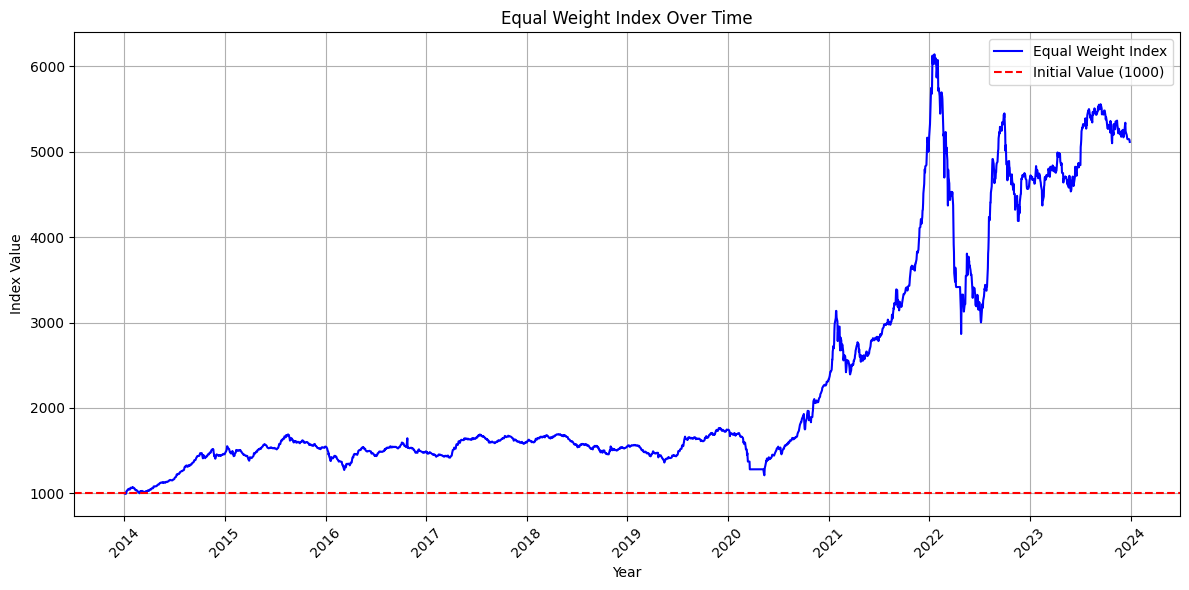

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(equal_weight_index.index, equal_weight_index, label='Equal Weight Index', color='blue')
plt.title('Equal Weight Index Over Time')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.axhline(y=1000, color='r', linestyle='--', label='Initial Value (1000)')
plt.legend()
plt.grid()

# Format the x-axis to show only the years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks for each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format to show only the year

plt.xticks(rotation=45)
plt.tight_layout()  # Prevent clipping of labels
plt.show()

# Feature Engineering

## Garman Klass Volatility

Volatility is an indicator of the speed of a stock price change. A stock with high volatility is one where the price changes rapidly and with a bigger amplitude. The more volatile a stock is, the riskier it is.

Garman Klass Volatility takes into account open, close, high and low prices of a stock, making it a accurate indicator to calculate volatility 

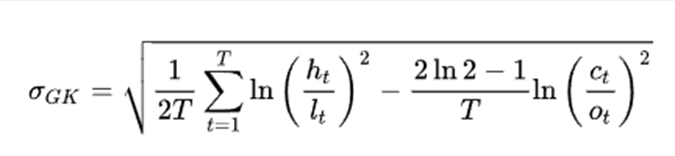

where;

• T - Number of days in the sample period

• o - Opening price on day t

• h - Highest price on day t

• l - Lowest price on day t

• c - Closing price on day t

In [12]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

## Momentum Indicators

Momentum indicators are technical analysis tools used to determine the strength or weakness of a stock's price trend. Momentum measures the rate of the rise or fall of stock prices. RSI and MACD are common momentum indicators.

### Relative Strength Index

RSI measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security. The RSI is displayed as an oscillator (a line graph) on a scale of zero to 100. RSI compares a security's strength on days when prices go up to its strength on days when prices go down. Relating the result of this comparison to price action can give traders an idea of how a security may perform. It can also indicate when to buy and sell. Traditionally, an RSI reading of 70 or above indicates an overbought situation. A reading of 30 or below indicates an oversold condition.

### Moving Average Convergence Divergence

MACD is a trend-following momentum indicator that shows the relationship between two exponential moving averages (EMAs) of a security’s price. The MACD line is calculated by subtracting the 26-period EMA from the 12-period EMA. A nine-day EMA of the MACD line is called the signal line, plotted on top of the MACD line, which can function as a trigger for buy or sell signals. Traders may buy the security when the MACD line crosses above the signal line and sell—or short—the security when the MACD line crosses below the signal line.

In [13]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

## Bollinger Bands

Bollinger Bands are 3 lines that move with the price of a stock. The center line is the stock price's 20-day simple moving average (SMA). The upper and lower bands are set at 2 standard deviations, above and below the middle line.

The bands widen when a stock's price becomes more volatile and contract when it is more stable. Many traders see stocks as overbought as their price nears the upper band and oversold as they approach the lower band, signaling an opportune time to trade.

In [14]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=x, length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=x, length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=x, length=20).iloc[:,2])

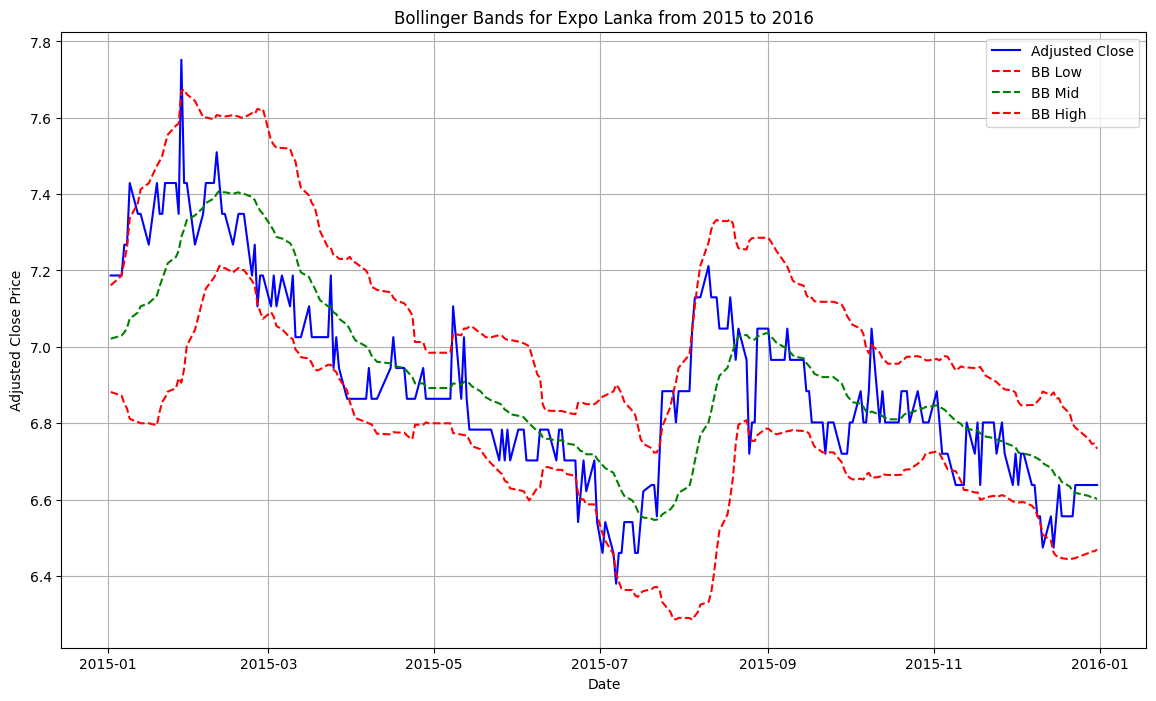

In [15]:
# Filter data to include price of Expo Lanka for one year
stock_id = 'EXPO-N0000.CM'
stock_data = df.xs(stock_id, level=1)
stock_data = stock_data.loc['2015-01-01':'2016-01-01']

plt.figure(figsize=(14, 8))
plt.plot(stock_data.index, stock_data['adj close'], label='Adjusted Close', color='blue')
plt.plot(stock_data.index, stock_data['bb_low'], label='BB Low', color='red', linestyle='--')
plt.plot(stock_data.index, stock_data['bb_mid'], label='BB Mid', color='green', linestyle='--')
plt.plot(stock_data.index, stock_data['bb_high'], label='BB High', color='red', linestyle='--')

# Fill between the bands for visual clarity
# plt.fill_between(stock_data.index, stock_data['bb_low'], stock_data['bb_high'], color='grey', alpha=0.3)

plt.title(f'Bollinger Bands for Expo Lanka from 2015 to 2016')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Average True range

The true range indicator is taken as the greatest of the following: 

• Current high minus the current low

• The absolute value of the current high minus the previous close

• The absolute value of the current low minus the previous close. 

The ATR is then a moving average, generally using 14 days, of the true ranges.

In [16]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

## Dollar Volume

Dollar volume liquidity refers to a stock's share price times its daily volume. It is important when making large trades. When there is a high level of investor interest in a stock or ETF, and it is traded on a major exchange, it will tend to be highly liquid. High dollar volume liquidity is generally a positive sign, meaning there is significant interest in the stock. However, some investors that employ certain strategies, such as trying to get into a stock before it becomes popular, might prefer stocks with low dollar volume liquidity. A stock can also have high dollar volume while it is falling in value, mainly because falling prices can result in panic selling which drives up the volume.

Calculating Dollar Volume is important for our next step to identify the 50 most liquid stocks

In [17]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                      adj close       close        high         low  \
Date       Ticker                                                          
2014-01-02 AAF-N0000.CM    18.750000   19.607843   20.588236   18.627451   
           AAIC-N0000.CM    5.422132    8.550000    8.550000    8.540000   
           ABAN-N0000.CM   83.430321  113.900002  116.000000  108.000000   
           ABL-N0000.CM          NaN         NaN         NaN         NaN   
           ACAP-N0000.CM   17.000000   17.000000   17.100000   16.500000   
...                              ...         ...         ...         ...   
2023-12-29 VPEL-N0000.CM    5.319755    7.200000    7.400000    7.100000   
           WAPO-N0000.CM   25.600000   25.600000   25.900000   25.000000   
           WATA-N0000.CM   66.984314   72.199997   73.000000   72.000000   
           WIND-N0000.CM   18.235176   19.200001   19.200001   19.000000   
           YORK-N0000.CM  151.000000  151.000000  145.250000  145.250000   

Price                           open     volume  garman_klass_vol        rsi  \
Date       Ticker                                                              
2014-01-02 AAF-N0000.CM    18.627451   468650.0          0.004992        NaN   
           AAIC-N0000.CM    8.540000    34550.0         -0.079716        NaN   
           ABAN-N0000.CM  108.000000    22821.0         -0.023184        NaN   
           ABL-N0000.CM          NaN        NaN               NaN        NaN   
           ACAP-N0000.CM   17.100000     3000.0          0.000625        NaN   
...                              ...        ...               ...        ...   
2023-12-29 VPEL-N0000.CM    7.200000  1088073.0         -0.034528  66.314890   
           WAPO-N0000.CM   25.500000     5811.0          0.000619  43.374172   
           WATA-N0000.CM   73.000000    16157.0         -0.002762  57.893775   
           WIND-N0000.CM   19.100000   111660.0         -0.000775  56.443511   
           YORK-N0000.CM  145.250000        4.0         -0.000582  23.689710   

Price                         macd      bb_low      bb_mid     bb_high  \
Date       Ticker                                                        
2014-01-02 AAF-N0000.CM        NaN         NaN         NaN         NaN   
           AAIC-N0000.CM       NaN         NaN         NaN         NaN   
           ABAN-N0000.CM       NaN         NaN         NaN         NaN   
           ABL-N0000.CM        NaN         NaN         NaN         NaN   
           ACAP-N0000.CM       NaN         NaN         NaN         NaN   
...                            ...         ...         ...         ...   
2023-12-29 VPEL-N0000.CM  0.909205    5.084861    5.212621    5.340381   
           WAPO-N0000.CM -0.974429   23.650607   26.225000   28.799393   
           WATA-N0000.CM  0.156015   65.199392   66.469408   67.739423   
           WIND-N0000.CM  0.189265   17.950253   18.102212   18.254171   
           YORK-N0000.CM -0.861404  143.291746  154.200000  165.108254   

Price                          atr  dollar_volume  
Date       Ticker                                  
2014-01-02 AAF-N0000.CM        NaN       8.787187  
           AAIC-N0000.CM       NaN       0.187335  
           ABAN-N0000.CM       NaN       1.903963  
           ABL-N0000.CM        NaN            NaN  
           ACAP-N0000.CM       NaN       0.051000  
...                            ...            ...  
2023-12-29 VPEL-N0000.CM -0.575267       5.788282  
           WAPO-N0000.CM -0.126128       0.148762  
           WATA-N0000.CM -0.121124       1.082266  
           WIND-N0000.CM -1.126454       2.036140  
           YORK-N0000.CM -0.309924       0.000604  

[714858 rows x 14 columns]

#### Aggregate to Monthly level

This conversion is useful for several reasons:

Reduce Data Size and Complexity: Monthly data has far fewer points than daily data, which significantly reduces the training time for machine learning models. This smaller dataset is easier to work with, especially during experimentation.

Capture Long-Term Trends: Month-end data smooths out short-term fluctuations (noise) that may not be relevant for long-term analysis. Monthly data often reveals underlying trends more clearly than daily data.

Experimental Analysis: Reducing data to monthly points allows for quicker experimentation with different features, modeling strategies, and parameters. Once you finalize a model or strategy, you can always go back to the higher-frequency daily data if needed.

Model Stability: Models trained on monthly data may generalize better in some cases, as they are less sensitive to daily volatility and outliers.

In [18]:
# Identify columns to retain at month-end
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

# Calculate the monthly average for 'dollar_volume'
# - Unstack the DataFrame by 'ticker' to get 'dollar_volume' for each ticker separately
# - Resample it to month-end frequency and take the mean for each month
# - Restack to bring 'ticker' back as a secondary index
dollar_volume_monthly = df.unstack('Ticker')['dollar_volume'].resample('ME').mean().stack('Ticker').to_frame('dollar_volume')

# Select the last value for each month for the remaining columns in `last_cols`
# - Unstack the DataFrame to get each column separately for each ticker
# - Resample it to month-end frequency and select the last value for each month
# - Stack to bring 'ticker' back as a secondary index
last_cols_monthly = df.unstack()[last_cols].resample('ME').last().stack('Ticker')

# Combine the monthly `dollar_volume` with the resampled `last_cols` data
# - Concatenate along columns and drop any rows with missing values
data = pd.concat([dollar_volume_monthly, last_cols_monthly], axis=1).dropna()

data

C:\Users\user\AppData\Local\Temp\ipykernel_14944\2837714626.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  last_cols_monthly = df.unstack()[last_cols].resample('ME').last().stack('Ticker')


dollar_volume   adj close  garman_klass_vol  \
Date       Ticker                                                       
2014-02-28 AAF-N0000.CM        4.368279   15.937500         -0.002377   
           AAIC-N0000.CM       0.084915    5.923771         -0.062238   
           ABAN-N0000.CM       0.122247   76.032204         -0.033488   
           ACAP-N0000.CM       0.039649   16.200001          0.000018   
           ACL-N0000.CM        0.888036   12.270065         -0.022323   
...                                 ...         ...               ...   
2023-12-31 VPEL-N0000.CM       1.137508    5.319755         -0.034528   
           WAPO-N0000.CM       5.751033   25.600000          0.000619   
           WATA-N0000.CM       1.614635   66.984314         -0.002762   
           WIND-N0000.CM      13.567071   18.235176         -0.000775   
           YORK-N0000.CM       0.017635  151.000000         -0.000582   

                                rsi      macd      bb_low      bb_mid  \
Date       Ticker                                                       
2014-02-28 AAF-N0000.CM   37.366287 -1.846030   15.207036   16.828125   
           AAIC-N0000.CM  52.510716 -0.045604    5.360068    5.847089   
           ABAN-N0000.CM  44.124024 -0.662039   72.137660   76.750034   
           ACAP-N0000.CM  42.425270 -0.726875   15.852445   16.695000   
           ACL-N0000.CM   44.187581 -0.238356   11.429704   12.600338   
...                             ...       ...         ...         ...   
2023-12-31 VPEL-N0000.CM  66.314890  0.909205    5.084861    5.212621   
           WAPO-N0000.CM  43.374172 -0.974429   23.650607   26.225000   
           WATA-N0000.CM  57.893775  0.156015   65.199392   66.469408   
           WIND-N0000.CM  56.443511  0.189265   17.950253   18.102212   
           YORK-N0000.CM  23.689710 -0.861404  143.291746  154.200000   

                             bb_high       atr  
Date       Ticker                               
2014-02-28 AAF-N0000.CM    18.449214  1.942755  
           AAIC-N0000.CM    6.334111 -0.487446  
           ABAN-N0000.CM   81.362409 -0.136771  
           ACAP-N0000.CM   17.537556  1.040077  
           ACL-N0000.CM    13.770972 -0.607378  
...                              ...       ...  
2023-12-31 VPEL-N0000.CM    5.340381 -0.575267  
           WAPO-N0000.CM   28.799393 -0.126128  
           WATA-N0000.CM   67.739423 -0.121124  
           WIND-N0000.CM   18.254171 -1.126454  
           YORK-N0000.CM  165.108254 -0.309924  

[29804 rows x 9 columns]

#### Calculate 5 year rolling average for dollar volume for each stock to filter the top 50 most liquid stocks

* Smoothing Out Volatility: A rolling average smooths out short-term fluctuations and noise in the dollar volume, providing a clearer view of a stock's liquidity over a longer period. This is particularly important in financial markets, where daily volume can vary significantly due to market conditions, news events, or seasonal trends.
* Identifying Trends: By examining the rolling average, analysts can identify trends in liquidity over time. This can help in understanding whether a stock is becoming more or less liquid, which is essential for investment decisions.
* Filtering for Liquidity: The top 50 most liquid stocks are often more desirable for traders and investors because they tend to have tighter bid-ask spreads and are less susceptible to price manipulation. Liquidity is crucial for executing trades efficiently without impacting the market price.
* Risk Management: Investing in liquid stocks can reduce execution risk, particularly for larger trades. By focusing on stocks with higher average dollar volumes, investors can more confidently enter and exit positions.
* Portfolio Construction: When building a portfolio, focusing on liquid stocks can improve the overall performance and reduce costs associated with trading, such as slippage and wider bid-ask spreads.

In [19]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('Ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('Date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<50].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi      macd  \
Date       Ticker                                                            
2015-01-31 AAF-N0000.CM   17.212500         -0.000773  46.613034 -0.877437   
           AEL-N0000.CM   18.586355         -0.042240  29.887225 -3.041062   
           AHUN-N0000.CM  68.449036         -0.009094  48.953922 -0.262231   
           ASIR-N0000.CM  15.357133         -0.043723  41.520852 -0.325144   
           BIL-N0000.CM    1.643478          0.001634  47.114248 -0.111445   
...                             ...               ...        ...       ...   
2023-12-31 SUN-N0000.CM   49.406250         -0.000431  52.984616  0.345563   
           TILE-N0000.CM  37.818367         -0.005972  42.336567 -0.401692   
           TJL-N0000.CM   35.627777         -0.000007  62.193449  0.353727   
           TKYO-N0000.CM  44.103092         -0.000392  46.184337 -0.408528   
           VONE-N0000.CM  36.118813         -0.001520  46.579094 -0.296074   

                             bb_low     bb_mid    bb_high       atr  
Date       Ticker                                                    
2015-01-31 AAF-N0000.CM   16.423777  17.977500  19.531223  1.706836  
           AEL-N0000.CM   16.680173  21.359902  26.039630  2.584132  
           AHUN-N0000.CM  65.800090  68.822162  71.844234  0.204051  
           ASIR-N0000.CM  15.101377  15.769768  16.438159 -0.686334  
           BIL-N0000.CM    1.530897   1.698261   1.865624 -0.537579  
...                             ...        ...        ...       ...  
2023-12-31 SUN-N0000.CM   48.344527  50.026250  51.707974  0.014515  
           TILE-N0000.CM  37.036801  38.745902  40.455003 -0.143983  
           TJL-N0000.CM   34.133776  34.940740  35.747705 -0.765923  
           TKYO-N0000.CM  42.269359  43.872989  45.476619  0.193237  
           VONE-N0000.CM  34.796501  36.372773  37.949046 -0.149512  

[5292 rows x 8 columns]

#### Calculate Monthly Returns for different time horizons as features.

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns over various monthly periods as identified by lags.

* Momentum Analysis: Many trading strategies, particularly momentum-based ones, rely on historical returns. If a stock has shown positive returns over the last few months, traders may anticipate that it will continue to perform well.
* Feature Engineering: In machine learning models, having multiple return features can improve predictive accuracy. For example, a model might learn that stocks with strong returns over the last three months are likely to continue performing well.
* Risk Assessment: Understanding monthly returns helps assess the risk associated with an investment. A stock with highly volatile monthly returns may pose higher risks than one with stable returns.
* Portfolio Management: Investors can use monthly returns to optimize their portfolios. By analyzing the performance of different stocks over various time frames, they can adjust their holdings to maximize returns while managing risk.

In [20]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi      macd  \
Date       Ticker                                                            
2016-01-31 AAF-N0000.CM   14.343750          0.001310  45.621346 -1.046806   
           AEL-N0000.CM   16.447245         -0.032592  49.538817 -0.464164   
           ASIR-N0000.CM  16.818565         -0.036801  45.628196 -0.320031   
           CFIN-N0000.CM  77.551018         -0.037591  27.837318 -1.122586   
           CIC-N0000.CM   17.928400         -0.030729  41.463908 -0.241149   
...                             ...               ...        ...       ...   
2023-12-31 SUN-N0000.CM   49.406250         -0.000431  52.984616  0.345563   
           TILE-N0000.CM  37.818367         -0.005972  42.336567 -0.401692   
           TJL-N0000.CM   35.627777         -0.000007  62.193449  0.353727   
           TKYO-N0000.CM  44.103092         -0.000392  46.184337 -0.408528   
           VONE-N0000.CM  36.118813         -0.001520  46.579094 -0.296074   

                             bb_low     bb_mid    bb_high       atr  \
Date       Ticker                                                     
2016-01-31 AAF-N0000.CM   13.216176  14.869688  16.523199  0.564124   
           AEL-N0000.CM   14.733056  16.279797  17.826537  0.308939   
           ASIR-N0000.CM  16.456498  16.983811  17.511124 -0.924663   
           CFIN-N0000.CM  76.096908  82.386317  88.675726 -0.475380   
           CIC-N0000.CM   17.627920  18.875242  20.122563 -0.371652   
...                             ...        ...        ...       ...   
2023-12-31 SUN-N0000.CM   48.344527  50.026250  51.707974  0.014515   
           TILE-N0000.CM  37.036801  38.745902  40.455003 -0.143983   
           TJL-N0000.CM   34.133776  34.940740  35.747705 -0.765923   
           TKYO-N0000.CM  42.269359  43.872989  45.476619  0.193237   
           VONE-N0000.CM  34.796501  36.372773  37.949046 -0.149512   

                          return_1m  return_2m  return_3m  return_6m  \
Date       Ticker                                                      
2016-01-31 AAF-N0000.CM   -0.111870  -0.031754  -0.021283  -0.029930   
           AEL-N0000.CM   -0.043290  -0.015471  -0.007493  -0.030516   
           ASIR-N0000.CM  -0.045833  -0.042921  -0.002894   0.006705   
           CFIN-N0000.CM  -0.110277  -0.041504  -0.022537  -0.027400   
           CIC-N0000.CM   -0.042872  -0.000520  -0.025553  -0.017035   
...                             ...        ...        ...        ...   
2023-12-31 SUN-N0000.CM    0.020000   0.051497  -0.002700   0.024639   
           TILE-N0000.CM  -0.020882  -0.011642  -0.035272  -0.015335   
           TJL-N0000.CM    0.043103   0.033270   0.005571   0.033840   
           TKYO-N0000.CM  -0.021277  -0.034048  -0.057825   0.005028   
           VONE-N0000.CM  -0.015385   0.000000  -0.051495   0.001016   

                          return_9m  return_12m  
Date       Ticker                                
2016-01-31 AAF-N0000.CM   -0.020054   -0.015079  
           AEL-N0000.CM    0.001129   -0.010137  
           ASIR-N0000.CM   0.005485    0.007604  
           CFIN-N0000.CM  -0.014692   -0.005850  
           CIC-N0000.CM    0.021538    0.013562  
...                             ...         ...  
2023-12-31 SUN-N0000.CM    0.019287    0.036394  
           TILE-N0000.CM   0.000264    0.005271  
           TJL-N0000.CM    0.016624    0.013237  
           TKYO-N0000.CM   0.005131    0.039214  
           VONE-N0000.CM   0.007764    0.022340  

[4280 rows x 14 columns]

## Fama French Factors

The capital asset pricing model (CAPM), is a financial model that calculates the expected rate of return for an asset or investment. It does this by considering the stocks risk-free rate, beta and Equity risk Premium.

* Risk-free rate - The theoretical rate of return of an investment with zero risk
* Beta - The systematic risk to the market
* Equity risk Premium - The additional return that's expected on a stock above the given risk-free rate.

The Fama and French Factors expand on the CAPM by adding size risk and value risk factors to the market risk factor in CAPM. This model considers the fact that value and small-cap stocks outperform markets on a regular basis. By including these two additional factors, the model adjusts for this outperforming tendency, which is thought to make it a better tool for evaluating manager performance.

The Fama and French 3-factor model accounts for:

1. The size of firm
2. Book-to-market value
3. Excess return on the market

In other words, it accounts for publicly traded companies with small market caps that generate higher returns (SMB), and value stocks with high book-to-market ratios that generate higher returns in comparison to the market (HML).

Researchers have expanded the 3-Factor model to include five factors. The new model adds the concepts:

4. Profitability - The concept of companies reporting higher future earnings have higher returns in the stock market
5. Investment - The concept of internal investment and returns, suggesting that companies directing profit towards major growth projects are likely to experience losses in the stock market.

In [27]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

# data is resampled to a monthly frequency
factor_data = factor_data.resample('ME').last().div(100)

factor_data.index.name = 'Date'

# merge factor_data with data, which contains the monthly returns calculated earlier
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

C:\Users\user\AppData\Local\Temp\ipykernel_14944\3663663083.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
C:\Users\user\AppData\Local\Temp\ipykernel_14944\3663663083.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',


Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                          
2016-01-31 AAF-N0000.CM  -0.0577 -0.0347  0.0209  0.0281  0.0307  -0.111870
           AEL-N0000.CM  -0.0577 -0.0347  0.0209  0.0281  0.0307  -0.043290
           ASIR-N0000.CM -0.0577 -0.0347  0.0209  0.0281  0.0307  -0.045833
           CFIN-N0000.CM -0.0577 -0.0347  0.0209  0.0281  0.0307  -0.110277
           CIC-N0000.CM  -0.0577 -0.0347  0.0209  0.0281  0.0307  -0.042872
...                          ...     ...     ...     ...     ...        ...
2023-12-31 SUN-N0000.CM   0.0487  0.0733  0.0492 -0.0304  0.0130   0.020000
           TILE-N0000.CM  0.0487  0.0733  0.0492 -0.0304  0.0130  -0.020882
           TJL-N0000.CM   0.0487  0.0733  0.0492 -0.0304  0.0130   0.043103
           TKYO-N0000.CM  0.0487  0.0733  0.0492 -0.0304  0.0130  -0.021277
           VONE-N0000.CM  0.0487  0.0733  0.0492 -0.0304  0.0130  -0.015385

[4280 rows x 6 columns]

## Rolling Factor Betas

Calculating rolling factor betas after obtaining the Fama-French model allows for a detailed understanding of the dynamic relationship between asset returns and risk factors. This analysis is important for making informed investment decisions, managing risk, and optimizing portfolio performance in a changing market environment.

* Dynamic Relationships: Financial markets are dynamic, and the relationship between asset returns and risk factors can change over time. Rolling betas capture these changes by recalculating betas based on the most recent data within the specified window.
* Momentum and Risk Assessment: By examining rolling betas, investors can assess how the sensitivity of an asset to various risk factors (like market risk, size, value, profitability, and investment) evolves. This helps identify momentum patterns and risk exposure.
* Portfolio Management: For portfolio managers, understanding how betas change over time aids in risk management and optimization strategies. If a stock's beta is increasing relative to a specific factor, it may indicate heightened risk, prompting a reassessment of its role in the portfolio.
* Performance Attribution: Rolling betas allow for better performance attribution by enabling a more nuanced analysis of how various factors contribute to asset performance over different time frames.
* Market Regime Changes: Financial markets experience regime changes (e.g., bull and bear markets). Rolling betas can help identify how asset exposures to risk factors change during different market conditions, which is vital for adapting investment strategies accordingly.

#### Filter out stocks with less than 10 months of data.

In [28]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('Ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                          
2016-01-31 AAF-N0000.CM  -0.0577 -0.0347  0.0209  0.0281  0.0307  -0.111870
           AEL-N0000.CM  -0.0577 -0.0347  0.0209  0.0281  0.0307  -0.043290
           ASIR-N0000.CM -0.0577 -0.0347  0.0209  0.0281  0.0307  -0.045833
           CFIN-N0000.CM -0.0577 -0.0347  0.0209  0.0281  0.0307  -0.110277
           CIC-N0000.CM  -0.0577 -0.0347  0.0209  0.0281  0.0307  -0.042872
...                          ...     ...     ...     ...     ...        ...
2023-12-31 SUN-N0000.CM   0.0487  0.0733  0.0492 -0.0304  0.0130   0.020000
           TILE-N0000.CM  0.0487  0.0733  0.0492 -0.0304  0.0130  -0.020882
           TJL-N0000.CM   0.0487  0.0733  0.0492 -0.0304  0.0130   0.043103
           TKYO-N0000.CM  0.0487  0.0733  0.0492 -0.0304  0.0130  -0.021277
           VONE-N0000.CM  0.0487  0.0733  0.0492 -0.0304  0.0130  -0.015385

[4242 rows x 6 columns]

#### To calculate the Rolling factor betas we use the RollingOLS linear regression model

In [29]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
Date       Ticker                                                         
2016-01-31 AAF-N0000.CM        NaN       NaN       NaN       NaN       NaN
           AEL-N0000.CM        NaN       NaN       NaN       NaN       NaN
           ASIR-N0000.CM       NaN       NaN       NaN       NaN       NaN
           CFIN-N0000.CM       NaN       NaN       NaN       NaN       NaN
           CIC-N0000.CM        NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2023-12-31 SUN-N0000.CM   0.317862 -2.433942  3.391375 -1.336759 -3.956500
           TILE-N0000.CM -0.030442 -1.858148  0.120411 -3.452452 -0.210165
           TJL-N0000.CM   0.381995  0.033234  1.604871  0.357171 -1.841301
           TKYO-N0000.CM -0.040722 -1.019486  0.732125 -1.403205 -2.033613
           VONE-N0000.CM -0.370716 -0.895286  1.976579 -2.545926 -2.494601

[4242 rows x 5 columns]

#### Join the rolling factors data to the main features dataframe.

In [31]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('Ticker').shift()))

data.loc[:, factors] = data.groupby('Ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4071 entries, (Timestamp('2016-01-31 00:00:00'), 'AEL-N0000.CM') to (Timestamp('2023-12-31 00:00:00'), 'VONE-N0000.CM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  4071 non-null   float64
 1   rsi               4071 non-null   float64
 2   macd              4071 non-null   float64
 3   bb_low            4071 non-null   float64
 4   bb_mid            4071 non-null   float64
 5   bb_high           4071 non-null   float64
 6   atr               4071 non-null   float64
 7   return_1m         4071 non-null   float64
 8   return_2m         4071 non-null   float64
 9   return_3m         4071 non-null   float64
 10  return_6m         4071 non-null   float64
 11  return_9m         4071 non-null   float64
 12  return_12m        4071 non-null   float64
 13  Mkt-RF            4071 non-null   float64
 14  SMB               4071 non-null   float6

# Fit a K-Means Clustering Algorithm to group similar assets based on their features for each month